# Validation against manual counts

In [72]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import sys
import pandas as pd
import PIL
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import scipy.stats as ss
import random

# Import wildcat
sys.path.append("wildcat.pytorch")
import wildcat.models

# Import wildcat mods
from unet_wildcat import *

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)
print("CUDA status: ", torch.cuda.is_available())
print("CUDA memory max alloc: %8.f MB" % (torch.cuda.max_memory_allocated() / 2.0**20))

PyTorch Version:  1.0.0
Torchvision Version:  0.2.2
CUDA status:  True
CUDA memory max alloc:     2774 MB


In [74]:
# Read the tangle counts dataframe
df=pd.read_csv('/home/pyushkevich/data/thon2019/tcount/manifest.csv')
df.head()

,id,slide_name,label_name,x,y,w,h,t_create,creator,t_edit,editor,specimen
0,12296,285359,rated_roi_01_rare,43900.687514,29515.919898,2047.0,2047.0,1.568735e+09,pyushkevich,1.570039e+09,dirwin,HNL-11-15
1,12298,285359,candidate_roi,43981.792455,7207.740622,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15
2,12299,285359,candidate_roi,17060.643622,22710.428107,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15
3,12300,285359,candidate_roi,3927.646902,7876.170117,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15
4,12301,285359,candidate_roi,34809.854645,28458.777831,2047.0,2047.0,1.568735e+09,pyushkevich,1.568735e+09,pyushkevich,HNL-11-15


In [87]:
# Get unique labels in the dataset
df['label_name'].unique()

array(['rated_roi_01_rare', 'candidate_roi', 'rated_roi_0_none',
       'rated_roi_1_mild', 'rated_roi_2_moderate', 'rated_roi_3_severe',
       'chosen_roi', 'tangle', 'pretangle', 'ask_dave', 'inprogress_roi'],
      dtype=object)

In [94]:
# Define the set of labels of worked up boxes. Check that all the boxes have been rated
box_labels={
    'rated_roi_0_none' : '0 (None)',
    'rated_roi_01_rare' : '0/1 (Rare)',
    'rated_roi_1_mild' : '1 (Mild)',
    'rated_roi_2_moderate': '2 (Moderate)',
    'rated_roi_3_severe': '3 (Severe)'
}

sum(df['label_name'].isin(box_labels.keys())), sum(df['label_name'] == 'finished_roi')

(140, 0)

Compute tangle counts per ROI

In [95]:
t_df = df[df['label_name']=='tangle']
r_df = df[df['label_name'].isin(box_labels)]
tc = []
ln = []
for index, row in r_df.iterrows():
    
    # Get all tangles on this slide
    t_slide = t_df[t_df['slide_name']==row['slide_name']]
    t_rect = t_slide[['x','y','w','h']].values
    t_cx,t_cy = (t_rect[:,0]+t_rect[:,2]*0.5,t_rect[:,1]+t_rect[:,3]*0.5)    
    
    # Find the centers that are inside
    x0,y0,x1,y1 = row['x'],row['y'],row['x']+row['w'],row['y']+row['h']
    inside = np.all(np.stack((t_cx >= x0, t_cx <= x1, t_cy >= y0,t_cy <= y1)), axis=0)
    tc.append(np.sum(inside))
    ln.append(box_labels[row['label_name']])
    
    
c_df = r_df[['id','slide_name','specimen']]
c_df['n_tangles']=tc
c_df['Label']=ln
c_df.head()

/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,id,slide_name,specimen,n_tangles,Label
0,12296,285359,HNL-11-15,1,0/1 (Rare)
11,12308,285359,HNL-11-15,1,0/1 (Rare)
19,12316,285359,HNL-11-15,1,0/1 (Rare)
29,12327,285359,HNL-11-15,0,0 (None)
44,12342,285346,HNL-11-15,0,0 (None)


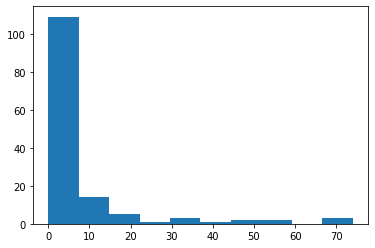

In [97]:
# Histogram of tangle counts
plt.hist(c_df['n_tangles'].values);

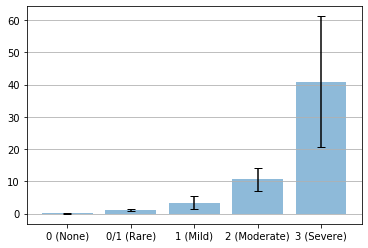

In [189]:
# Tangle counts by label
def cat_plot(c_df, yvar, scale=1):
    l_nt_mean = list(map(lambda x : np.mean(c_df[c_df['Label']==x][yvar]*scale), box_labels.values()))
    l_nt_sd = list(map(lambda x : np.std(c_df[c_df['Label']==x][yvar]*scale), box_labels.values()))
    x_pos = range(len(box_labels.keys()))
    fig, ax = plt.subplots()
    ax.bar(x_pos, l_nt_mean, yerr=l_nt_sd, align='center', alpha=0.5, ecolor='black', capsize=4);
    ax.set_xticks(x_pos)
    ax.set_xticklabels(box_labels.values())
    ax.yaxis.grid(True)
    return ax

cat_plot(c_df, 'n_tangles');

In [158]:
# Cohen's D table between all classes
def cohend(y1, y2):
    m1, m2 = np.mean(y1), np.mean(y2)
    s1, s2 = np.std(y1), np.std(y2)
    n1, n2 = len(y1), len(y2)
    s = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1+n2-2))
    return (m1-m2) / s

def cohend_table(c_df, yvar):
    val = list(box_labels.values())
    n=len(box_labels.values())
    C=np.ones((n,n)) * np.nan
    for i in range(n):
        for j in range(i):
            yi = c_df[c_df['Label']==val[i]][yvar]
            yj = c_df[c_df['Label']==val[j]][yvar]
            C[i,j] = cohend(yi,yj)
    return C

cohend_table(c_df, 'n_tangles')

array([[       nan,        nan,        nan,        nan,        nan],
       [4.17527883,        nan,        nan,        nan,        nan],
       [2.70001213, 1.4776981 ,        nan,        nan,        nan],
       [5.8396579 , 3.95601339, 2.75051768,        nan,        nan],
       [4.17346318, 3.04751045, 3.28406026, 2.15426991,        nan]])

In [212]:
# T-test p-value table
def pval_table(c_df, yvar, stat='f'):
    val = list(box_labels.values())
    n=len(box_labels.values())
    C=np.ones((n,n)) * np.nan
    for i in range(n):
        for j in range(i):
            yi = c_df[c_df['Label']==val[i]][yvar]
            yj = c_df[c_df['Label']==val[j]][yvar]
            [U,p] = ss.mannwhitneyu(yi,yj,alternative='greater')
            C[i,j] = U / (len(yi) * len(yj)) if stat == 'f' else p if stat == 'p' else U if stat == 'U' else None
    return C

pval_table(c_df, 'n_tangles', stat='f')

array([[       nan,        nan,        nan,        nan,        nan],
       [0.96863636,        nan,        nan,        nan,        nan],
       [0.99852941, 0.90374332,        nan,        nan,        nan],
       [1.        , 1.        , 0.97303922,        nan,        nan],
       [1.        , 1.        , 0.99908088, 0.93055556,        nan]])

In [120]:
# Global properties
num_classes=2
input_size=224
input_size_wildcat=224
batch_size=16
batch_size_wildcat=16
resnet_flavor=18
data_dir = "/home/pyushkevich/data/thon2019/tcount"
model_dir = "/home/pyushkevich/resnet/thon2019/exp01"
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#train_dir = "/home/pyushkevich/resnet/thon2019/exp01"

In [121]:
# Load each of the models in turn
folds=os.listdir(model_dir)
fold_models={}
for f in folds:
    print('Loading model for ', f)
    fold_model_dir=os.path.join(model_dir, f)
    fold_models[f] = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
    fold_models[f].load_state_dict(torch.load(os.path.join(fold_model_dir, "model_%s_wcu_50_15epoch.dat" % (f,))))
    fold_models[f].eval()
    fold_models[f] = fold_models[f].to(device)

Loading model for  fold_INDD106312
Loading model for  fold_INDD107677
Loading model for  fold_INDD119294
Loading model for  fold_HNL-11-15
Loading model for  fold_HNL-29-18
Loading model for  fold_INDD116748


In [123]:
# Load the common model (trained on all 6)
model_main = resnet50_wildcat_upsample(2, pretrained=False, kmax=0.02, alpha=0.7, num_maps=4)
model_main.load_state_dict(torch.load("/home/pyushkevich/resnet/thon2019/tcount/wildcat_upsample.dat"))
model_main.eval()
model_main = model_main.to(device)

In [124]:
# Main loop for scanning ROIs
tload=[]
tmaxcnt=[]
tpatch={}
ipatch={}
for index, row in c_df.iterrows():
    
    # Load the image
    fn='%s/samples/%d.png' % (data_dir,row['id'])
    img=PIL.Image.fromarray(np.uint8(np.asarray(PIL.Image.open(fn))[:,:,0:3]))
    ipatch[row['id']] = img
    
    # Size of the roi
    roi_dim = np.array(img.size)

    # Compute the desired size of input to wildcat
    wwc = (roi_dim * input_size_wildcat / 512).astype(int)

    # Resample the chunk for the two networks
    tran = transforms.Compose([
        transforms.Resize((wwc[0],wwc[1])),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    # Select the model for this specimen
    sf = "fold_%s" % (row['specimen'],)
    if sf not in folds:
        sf = random.choice(folds)

    print('Sample %d   Specimen %s   Fold %s' % (row['id'],row['specimen'],sf))

    # Convert the read chunk to tensor format
    with torch.no_grad():

        # Apply transforms and turn into correct-size torch tensor
        chunk_tensor=torch.unsqueeze(tran(img),dim=0).to(device)

        # Forward pass through the wildcat model
        x_clas = model_main.forward_to_classifier(chunk_tensor)
        x_cpool = model_main.spatial_pooling.class_wise(x_clas)

        # Threshold
        x_thresh = (x_cpool[0,1,:,:] - x_cpool[0,0,:,:]).cpu().detach().numpy()
        x_thresh[x_thresh < 0.0] = 0.0
        
        tpatch[row['id']]=x_thresh;
        tload.append(x_thresh.sum())   
        
        # Count - add another threshold
        zz = x_thresh
        zz[zz < 1.0] = 0.0
        
        tmaxcnt.append(len(peak_local_max(zz, min_distance=10)))
        
c_df['tangle_load']=tload
c_df['tangle_maxcnt']=tmaxcnt



Sample 12296   Specimen HNL-11-15   Fold fold_HNL-11-15


/home/pyushkevich/miniconda3/lib/python3.7/site-packages/torch/nn/modules/upsampling.py:129: UserWarning: nn.Upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.{} is deprecated. Use nn.functional.interpolate instead.".format(self.name))


Sample 12308   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12316   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12327   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12342   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12348   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12350   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12352   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12381   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12383   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12385   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12400   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12435   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12443   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12446   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12447   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12468   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12475   Specimen HNL-11-15   Fold fold_HNL-11-15
Sample 12481   Specimen HNL-11-15   Fold fold_HN

/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/pyushkevich/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


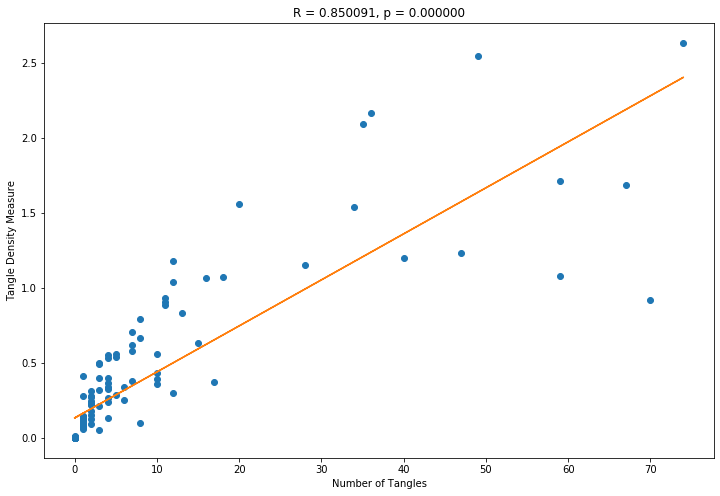

In [163]:
# Plot the stats
xi=c_df['n_tangles']
y=c_df['tangle_load'] / 448**2

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(12,8))
plt.plot(xi,y,'o', xi, line)
plt.title('R = %f, p = %f' % (r_value, p_value));
plt.xlabel('Number of Tangles');
plt.ylabel('Tangle Density Measure');

In [164]:
ss.spearmanr(xi,y),ss.kendalltau(xi,y),ss.pearsonr(xi,y)

(SpearmanrResult(correlation=0.9444831900796592, pvalue=1.4074239707708846e-68),
 KendalltauResult(correlation=0.8284280093329328, pvalue=1.623447332312295e-41),
 (0.8500907855390532, 2.9446945383922222e-40))

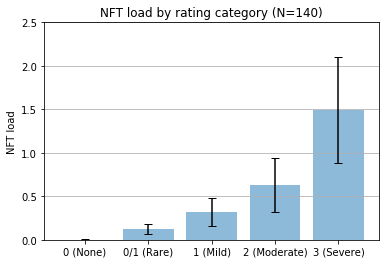

In [203]:
ax = cat_plot(c_df, 'tangle_load', 1.0/448**2);
ax.set_title('NFT load by rating category (N=140)');
ax.set_ylabel('NFT load');
ax.set_ylim((0,2.5));

In [213]:
pd.DataFrame(pval_table(c_df, 'n_tangles', stat='f'),columns=box_labels.values(), index=box_labels.values())

,0 (None),0/1 (Rare),1 (Mild),2 (Moderate),3 (Severe)
0 (None),NaN,NaN,NaN,NaN,NaN
0/1 (Rare),0.968636,NaN,NaN,NaN,NaN
1 (Mild),0.998529,0.903743,NaN,NaN,NaN
2 (Moderate),1.000000,1.000000,0.973039,NaN,NaN
3 (Severe),1.000000,1.000000,0.999081,0.930556,NaN


In [218]:
# Mann-Whitney AUC (all boxes)
pd.DataFrame(pval_table(c_df, 'tangle_load', stat='f'),columns=box_labels.values(), index=box_labels.values())

,0 (None),0/1 (Rare),1 (Mild),2 (Moderate),3 (Severe)
0 (None),NaN,NaN,NaN,NaN,NaN
0/1 (Rare),0.959545,NaN,NaN,NaN,NaN
1 (Mild),0.999412,0.875668,NaN,NaN,NaN
2 (Moderate),1.000000,0.957071,0.795752,NaN,NaN
3 (Severe),1.000000,1.000000,0.979779,0.913194,NaN


In [219]:
# Mann-Whitney P-value (all boxes)
pd.DataFrame(pval_table(c_df, 'tangle_load', stat='p'),columns=box_labels.values(), index=box_labels.values())

,0 (None),0/1 (Rare),1 (Mild),2 (Moderate),3 (Severe)
0 (None),NaN,NaN,NaN,NaN,NaN
0/1 (Rare),2.181135e-10,NaN,NaN,NaN,NaN
1 (Mild),3.704136e-15,1.264241e-06,NaN,NaN,NaN
2 (Moderate),1.328371e-10,4.620741e-07,2.584946e-04,NaN,NaN
3 (Severe),7.242548e-10,1.058459e-07,3.018770e-08,0.000022,NaN


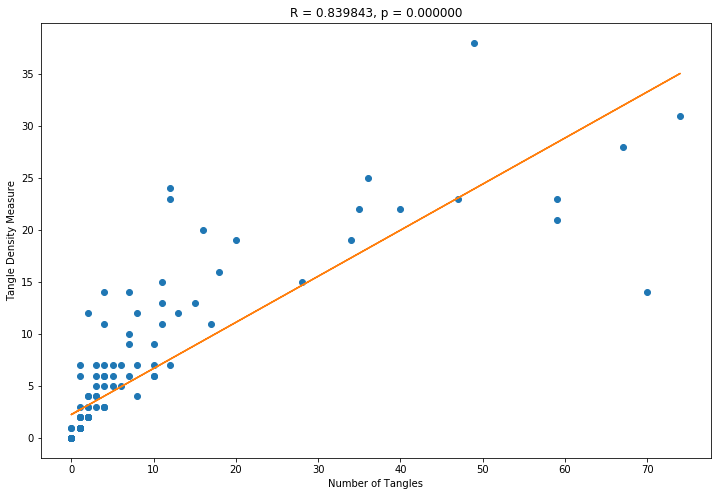

In [134]:
xi=c_df['n_tangles']
y=c_df['tangle_maxcnt']

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(12,8))
plt.plot(xi,y,'o', xi, line)
plt.title('R = %f, p = %f' % (r_value, p_value));
plt.xlabel('Number of Tangles');
plt.ylabel('Tangle Density Measure');

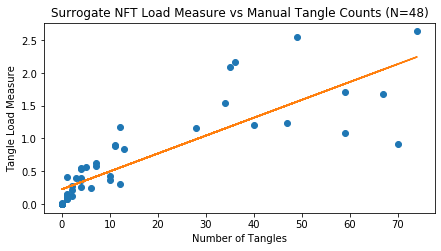

In [182]:
# Look only at subset that are not trained on
c_df_oot=pd.concat((c_df[c_df['specimen'] == 'HNL-32-18'],c_df[c_df['specimen'] == 'HNL-34-18'],c_df[c_df['specimen'] == 'HNL-35-18']))
# Plot the stats
xi=c_df_oot['n_tangles']
y=c_df_oot['tangle_load'] / 448**2

slope, intercept, r_value, p_value, std_err = ss.linregress(xi,y)
line = slope*xi+intercept
plt.figure(figsize=(7,3.5))
plt.plot(xi,y,'o', xi, line)
plt.title('Surrogate NFT Load Measure vs Manual Tangle Counts (N=48)');
plt.xlabel('Number of Tangles');
plt.ylabel('Tangle Load Measure');
plt.savefig('figs/tcount_corr_oot_wide.pdf', bbox_inches = 'tight', pad_inches = 0.25)

In [181]:
ss.spearmanr(xi,y),ss.kendalltau(xi,y),ss.pearsonr(xi,y)

(SpearmanrResult(correlation=0.940806072073073, pvalue=3.016462746779279e-23),
 KendalltauResult(correlation=0.8122077344297151, pvalue=3.214304377818893e-15),
 (0.837748499197327, 1.1330305293325836e-13))

In [140]:
ss.kendalltau(xi,y)

KendalltauResult(correlation=0.8122077344297151, pvalue=3.214304377818893e-15)

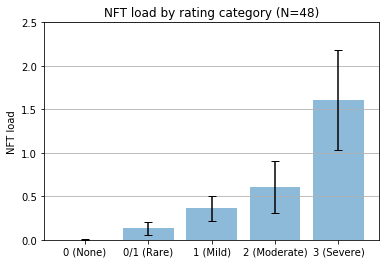

In [225]:
ax = cat_plot(c_df_oot, 'tangle_load', 1.0/448**2);
ax.set_title('NFT load by rating category (N=%d)' % len(c_df_oot));
ax.set_ylabel('NFT load');
ax.set_ylim((0,2.5));
plt.savefig('figs/tcount_cat_oot_wide.pdf', bbox_inches = 'tight', pad_inches = 0.25)

In [224]:
pd.DataFrame(pval_table(c_df_oot, 'tangle_load', stat='f'),columns=box_labels.values(), index=box_labels.values())

,0 (None),0/1 (Rare),1 (Mild),2 (Moderate),3 (Severe)
0 (None),NaN,NaN,NaN,NaN,NaN
0/1 (Rare),1.0,NaN,NaN,NaN,NaN
1 (Mild),1.0,0.927273,NaN,NaN,NaN
2 (Moderate),1.0,0.977778,0.747475,NaN,NaN
3 (Severe),1.0,1.000000,1.000000,0.957265,NaN


In [221]:
pd.DataFrame(pval_table(c_df_oot, 'tangle_load', stat='p'),columns=box_labels.values(), index=box_labels.values())

,0 (None),0/1 (Rare),1 (Mild),2 (Moderate),3 (Severe)
0 (None),NaN,NaN,NaN,NaN,NaN
0/1 (Rare),0.001123,NaN,NaN,NaN,NaN
1 (Mild),0.000056,0.004585,NaN,NaN,NaN
2 (Moderate),0.000123,0.002555,0.034124,NaN,NaN
3 (Severe),0.000029,0.000804,0.000019,0.000201,NaN


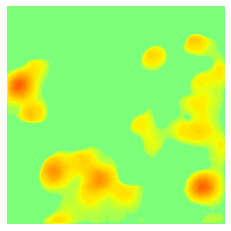

In [64]:
k=12701
# k=12831
# k=13032
zz=tpatch[k];
zz[zz < 1.0] = 0.0
ax=plt.imshow(tpatch[k],clim=(-10,10),cmap='jet')
plt.axis('off')
maxima=peak_local_max(zz, min_distance=10)
plt.savefig('figs/tcount_patch_%d.pdf' % k, bbox_inches = 'tight', pad_inches = 0)
# plt.plot(maxima[:, 1], maxima[:, 0], 'b.')

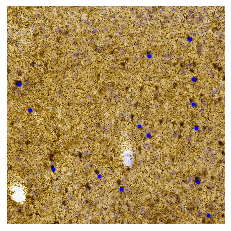

In [65]:
plt.imshow(ipatch[k]);
plt.plot(maxima[:, 1]*512/114, maxima[:, 0]*512/114, 'b.')
plt.axis('off');

In [179]:
c_df[c_df['n_tangles']>60]

,id,slide_name,specimen,n_tangles,Label,tangle_load,tangle_maxcnt
397,12701,HNL-32-18_HR1a_TAU_26,HNL-32-18,70,3 (Severe),184560.21875,14
471,12776,HNL-32-18_HR3a_TAU_10,HNL-32-18,74,3 (Severe),528751.43750,31
599,12908,HNL-34-18_HR2a_TAU_16,HNL-34-18,67,3 (Severe),337868.28125,28


In [185]:
np.sqrt(zz.size)

448.0